In [ ]:
from RBM_surrogate import *
from New_MCMC_Proposal import *
#from Mixed_RBM import *

In [2]:
import numpy as np
import numpy.linalg as la
import time
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf

2025-02-27 22:16:57.752613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 22:16:57.942938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740694617.999936    7199 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740694618.015480    7199 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 22:16:58.144797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
N=1
M=1
D=0
beta=1

In [4]:
def init(seed=1, vv=False, complex=True, a=[], b=[], w=[]):
  np.random.seed(seed)
  if complex==True:
    X=np.random.randn(N+M+N*M+N*D+D+N*N)+1j*np.random.randn(N+M+N*M+N*D+D+N*N)
  else:
    X=np.random.randn(N+M+N*M+N*D+D+N*N)

  if vv==False:
    X[-N*N:] = np.zeros(N*N)
  else:
    c=np.reshape(X[-N*N:],(N,N))
    np.fill_diagonal(c,0)
    X[-N*N:] = np.reshape(c,-1)

  if len(a)!=0:
    X[:N] = a
  if len(b)!=0:
    X[N:N+M] = b
  if len(w)!=0:
    X[N+M:N+M+N*M] = np.reshape(w,-1)

  X=np.concatenate((np.real(X),np.imag(X)))
  return X

In [5]:
def get_params(x):
  a=x[:N] +1j*x[N:2*N]
  b=x[2*N:2*N+M] + 1j*x[2*N+M:2*(N+M)]
  #w=np.reshape(x[N+M:],(N,M))
  w=np.reshape(x[2*(N+M):2*(N+M)+N*M]+1j*x[2*(N+M)+N*M:],(N,M))
  u=np.zeros((N,D))
  d=np.zeros(D)
  c=np.zeros((N,N))
  return a,b,w,u,d,c


def fun(x):
  E_smpl = smpl.Energy_sampling(H,prob_dist)
  return E_smpl

def get_grad_params(X):
  l = len(X)//2

  a=X[:N]+1j*X[l:l+N]
  b=X[N:N+M]+1j*X[l+N:l+N+M]
  w=np.reshape(X[N+M:N+M+N*M]+1j*X[l+N+M:l+N+M+N*M],(N,M))
  u=np.reshape(X[N+M+N*M:N+M+N*M+N*D]+1j*X[l+N+M+N*M:l+N+M+N*M+N*D],(N,D))
  d=X[N+M+N*M+N*D:N+M+N*M+N*D+D]+1j*X[l+N+M+N*M+N*D:l+N+M+N*M+N*D+D]
  c=np.reshape(X[N+M+N*M+N*D+D:l]+1j*X[l+N+M+N*M+N*D+D:],(N,N))
  return a,b,w,u,d,c

def jac(x,exact_comp=False):
  grad = smpl.grad_Sampling(H,prob_dist)
  grad_hist.append(grad)
  da, db, dw, _, _, _ = get_grad_params(grad)

  '''with open(file+"grad_smpl_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(grad,(1,-1)))'''

  if exact_comp == True:
    grad_exact = smpl.grad_exact(H)
    grad_err_hist.append(la.norm(grad - grad_exact))
    print("Gradient Norm: ", la.norm(grad_exact), "\t +/- \t", la.norm(grad - grad_exact))
    '''with open(file+"grad_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
      np.savetxt(f, np.reshape(grad_exact,(1,-1)))'''

    #grad_hist.append(grad_exact)
    #da, db, dw, _, _, _ = get_grad_params(grad_exact)
    #return np.concatenate((da,db,np.reshape(dw,-1)))

  return np.concatenate((np.real(da),np.imag(da),np.real(db),np.imag(db),np.reshape(np.real(dw),-1),np.reshape(np.imag(dw),-1)))
  #return np.concatenate((da,db,np.reshape(dw,-1)))

In [6]:
def Sampling(Proposal_object, Transition_matrix, sample_size=10000, burn=1000, method='Quantum', init_config=None):
  prob_dist = np.zeros(2**N)

  exact_dist = np.exp(-beta * Proposal_object.Energy_array)
  exact_dist = exact_dist / np.sum(exact_dist)

  #err_hist = []
  key_list = []

  if init_config==None:
    s = np.random.choice([1,-1],size=N)
  else: s = init_config

  for k in range(burn):
    s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)

  for k in range(sample_size):
    s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
    key = Proposal_object.get_spinconfig_to_int(s)
    prob_dist[key] +=1
    key_list.append(key)

    #if k%1000 == 999: err_hist.append(np.linalg.norm(exact_dist - prob_dist/np.sum(prob_dist)))

  return np.flip(prob_dist/np.sum(prob_dist)), key_list     #This flip is required to make peace with the difference in the convention.
  #err_hist

In [7]:
# Adam optimizer hyperparameters
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [16]:
pwd

'/home/cudaq/Quantum-Sampling/Archive'

In [ ]:
Ham = np.load("graphene_hamiltonian.npy")

exact_energy = []

for i in range(len(Ham)):
    H = Ham[i]
    lmbd,eigvec=np.linalg.eigh(H)
    exact_energy.append(lmbd[0])

    sample_size = 20000

    seed = 0

    E_hist=[]
    E_err_hist=[]
    grad_hist=[]
    grad_err_hist=[]

    X=init(seed, complex=True)/100

    smpl = Sampling_Quantum_vectorized(X,N,M,D,beta=beta)
    a,b,w,_,_,_ = smpl.get_params()

    x0=np.concatenate((np.real(a),np.imag(a),np.real(b),np.imag(b),np.reshape(np.real(w),-1),np.reshape(np.imag(w),-1)))

    tm=time.time()

    x = tf.Variable(x0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

    for epoch in range(40):
    X = x.numpy()

    a,b,w,u,d,c = get_params(X)
    X=np.concatenate((a,b,np.reshape(w,-1),np.reshape(u,-1),d,np.reshape(c,-1)))
    X=np.concatenate((np.real(X),np.imag(X)))

    smpl = Sampling_Quantum_vectorized(X,N,M,D,beta=beta)

    one_body_coeffs = -smpl.poly[1:1+N]     #np.random.rand(n)
    two_body_coeffs = -smpl.poly[1+N:]      #np.random.rand(n**2)

    E = smpl.Energy_exact(H)

    Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
                two_body_coeffs = two_body_coeffs)

    Proposal_matrix = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Trotter error/no Sampling error")
    Proposal_matrix_exact = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error")

    proposal_norm = np.linalg.norm(Proposal_matrix_exact)
    trotter_error = np.linalg.norm(Proposal_matrix_exact - Proposal_matrix)

    Proposal_object.get_energy_array().Energy_array
    Transition_matrix = np.real(Proposal_object.get_transition_matrix_from_proposal(Proposal_matrix, acceptance_criteria='metropolis'))

    prob_dist, sample_list = Sampling(Proposal_object, Transition_matrix, sample_size, burn=sample_size//10)

    E_smpl = fun(x)
    print("Energy: ", E, "\t +/- \t", np.abs(E_smpl - E))
    grad = jac(x)

    optimizer.apply_gradients([(grad, x)])

    E_hist.append(E_smpl)
    E_err_hist.append(np.abs(E_smpl - E))

    #Calculating quantities
    s = smpl.enum(N)
    local_energies = smpl.local_energy(H,s)
    kernels = smpl.kernel(s)
    phi = smpl.prob(s)

    derivative_op_diag = np.zeros((12,2**N),dtype=complex)
    local_gradients = np.zeros((12,2**N),dtype=complex)
    s_vec = np.reshape(s, (len(s),1,N))

    da,db,dw,du,dd,dc = get_params(grad)
    dw = np.reshape(dw,-1)

    idx_list = np.array([np.argmin(np.abs(da)), np.argmax(np.abs(da)), N+np.argmin(np.abs(db)), N+np.argmax(np.abs(db)), N+M+np.argmin(np.abs(dw)), N+M+np.argmax(np.abs(dw))])
    idx_list = np.concatenate((idx_list,idx_list+N+M+N*M+N*D+D+N*N))

    for i in range(12):
        idx = idx_list[i]
        var, _, _ = smpl.map_idx_to_var(idx)
        local_gradients[i] = smpl.local_gradient(H,s,idx)
        derivative_op_diag[i] = smpl.derivative_operator(s,s_vec,idx)[:,0]

    print("\n\n\nEnergy: ",fun(x),"\n Time",time.time()-tm, lmbd[0])

    #ya, iter = smpl.median_filter(np.real(E_hist))
    ya = np.real(E_hist)
    xa = np.arange(len(ya))
    ci = np.array(E_err_hist) #[iter]
    fig, ax = plt.subplots()
    ax.plot(ya)
    ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
    ax.set_ylabel("Energy")
    ax.set_xlabel("Epochs")
    plt.hlines(lmbd[0],0,len(xa)-1,color='r',linestyles='dashed')
    plt.show()



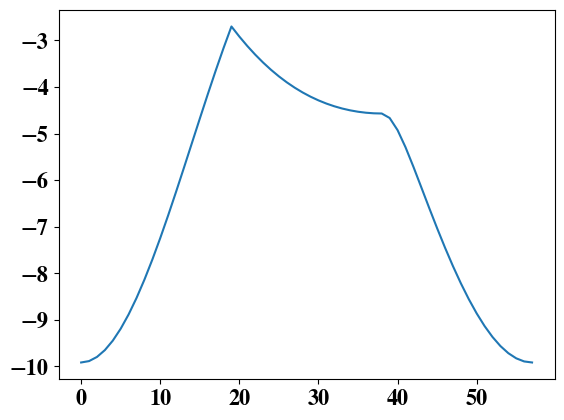

In [ ]:
plt.plot(exact_energy)

Energy:  -4.100454402577146 	 +/- 	 0.0007375702178142873
Energy:  -4.202368561090254 	 +/- 	 0.0004200618384047061
Energy:  -4.302645035351745 	 +/- 	 0.0003138016415498157
Energy:  -4.40359516967076 	 +/- 	 0.0001286055210236725
Energy:  -4.505084103608776 	 +/- 	 9.690941355167126e-05
Energy:  -4.606988136154948 	 +/- 	 0.0002392683904677284
Energy:  -4.709195412703962 	 +/- 	 0.00014255595781609287
Energy:  -4.811891917922267 	 +/- 	 0.0002438298565126118
Energy:  -4.91517652283823 	 +/- 	 0.00022654200033844774
Energy:  -5.01862219579243 	 +/- 	 0.0004426495753557802
Energy:  -5.121913749889038 	 +/- 	 0.000154344202981882
Energy:  -5.225049228372572 	 +/- 	 0.0003040196553811825
Energy:  -5.328010667855314 	 +/- 	 0.00035954100692681124
Energy:  -5.430911410106502 	 +/- 	 0.0002495772202344426
Energy:  -5.53367032362218 	 +/- 	 4.3478786341033526e-05
Energy:  -5.636435267232023 	 +/- 	 7.244032725584049e-05
Energy:  -5.739300883611631 	 +/- 	 0.0004990762410841398
Energy:  -5.841

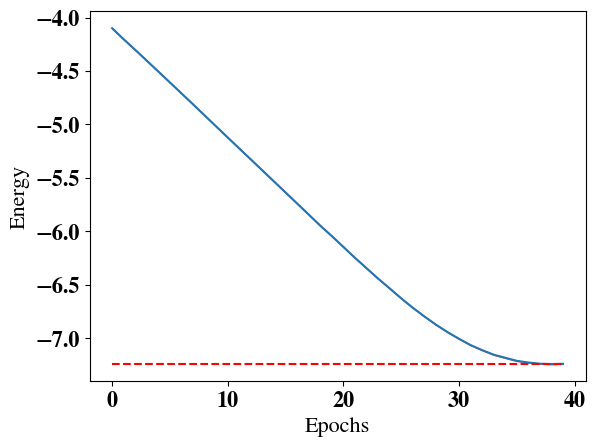

dictionary saved successfully to file
